### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) MSE  $\nabla L(a(x_i), y_i) = -2(y_i - a(x_i))$

2) Экспоненциальная  $\nabla L(a(x_i), y_i) = -y_i exp( -a(x_i) y_i)$

3) Логистическая  $\nabla L(a(x_i), y_i) = \frac{-y_i}{1 + exp( -a(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=10, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.models = []
        self.features = []
        
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        init_pred = 0
        init_L = 0
        n = y.size
        m = X.shape[1]
        k1 = np.arange(m)
        k2 = np.arange(n)
        m_ = round(m * self.colsample)
        n_ = round(n * self.subsample)
        if init_model is not None:
            model = init_model
            model.fit(X, y) 
            self.models.append(model)
            self.features.append(np.arange(m))
            yi = np.array(model.predict(X))
        else:
            yi = y
        
        
        for i in range(self.n_estimators):
            colsample = shuffle(k1, random_state=0)
            X_f = X[:, colsample[:m_]]
            
            subsample = shuffle(k2, random_state=0)
            subsample = subsample[:n_]
            X_shuffle = X_f[subsample, :]
            
            
            y_sample = y[subsample]
            
            self.features.append(colsample[:m_])
            
            model = base_model(*self.args, **self.kwargs)
            model.fit(X_shuffle, yi[subsample])
            
            y_pred = model.predict(X_f)
            gradient = self._func_(y_sample, y_pred[subsample])
            yi[subsample] = y_sample - self.learning_rate*gradient
            self.models.append(model)
            
            """
            Версия без шафла для отладки
            model = base_model(*self.args, **self.kwargs)
            model.fit(X, yi)
            
            y_pred = model.predict(X)
            gradient = self._func_(y, y_pred)
            yi = y - self.learning_rate*gradient
            self.models.append(model)
            """
        
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            pred += self.learning_rate * self.models[i].predict(X[:, self.features[i]])
        return np.around(pred)

    def _func_(self, y, y_pred):
        if self.loss == 'mse':
            return -2*(y - y_pred)
        if self.loss == 'exp':
            return -y*np.exp(-y*y_pred)
        if self.loss == 'log':
            return -y/(1 + np.exp(-y*y_pred))

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8333333333333334
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
scores = []
for i in range(5, 25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf = MyGradientBoostingClassifier(n_estimators=i, max_depth=5)
    my_clf.fit(X_train, y_train)
    
    score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    scores.append(score)

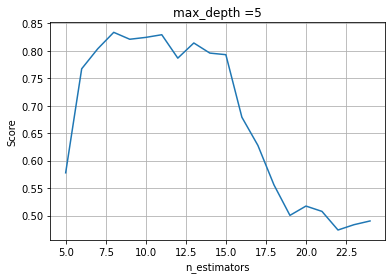

In [9]:
fig = plt.figure(40)
ax = fig.add_subplot(111)
ax.grid(True)
x = np.arange(5, 25)
ax.plot(x, scores)
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title("max_depth =" + str(5))
plt.show()

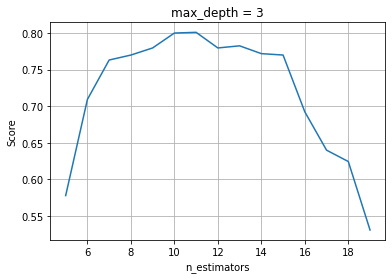

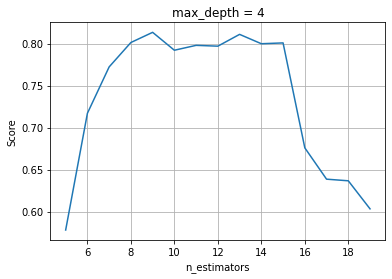

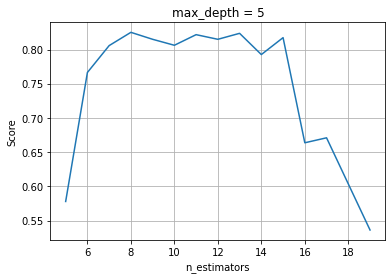

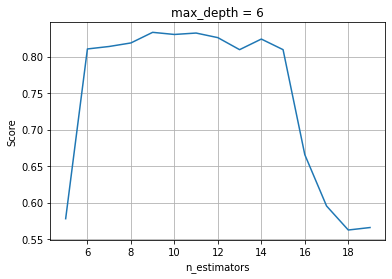

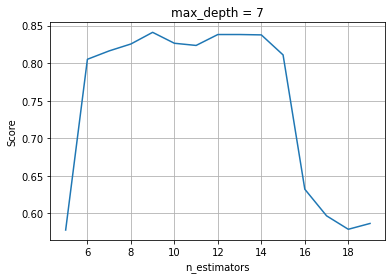

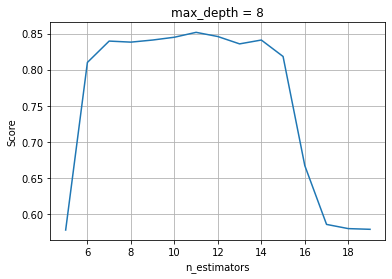

In [10]:
depths = [3, 4, 5, 6, 7, 8]
for depth in depths:
    scores = []
    for i in range(5, 20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        my_clf = MyGradientBoostingClassifier(n_estimators=i, max_depth=depth)
        my_clf.fit(X_train, y_train)

        score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
        scores.append(score)
    fig = plt.figure(40)
    ax = fig.add_subplot(111)
    ax.grid(True)
    x = np.arange(5, 20)
    ax.plot(x, scores)
    plt.xlabel('n_estimators')
    plt.ylabel('Score')
    plt.title("max_depth = " + str(depth))
    plt.show()

Из приведенных выше графиков видно, что оптимальный вариант max_depth = 8 и число итераций примерно 8-11

In [13]:
losss = ['mse', 'exp', 'log']
subs = [0.2, 0.6, 0.8, 1]
cols = [0.2, 0.6, 0.8, 1]
lrs = [0.1, 0.3, 0.5]

scores = []
params = []

for loss in losss:
    for sub in subs:
        for col in cols:
            for lr in lrs:
                params.append((loss, sub, col, lr))
                
                my_clf = MyGradientBoostingClassifier(loss =loss, learning_rate=lr, n_estimators=11,
                                       colsample=col, subsample=sub, max_depth = 8)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
                my_clf.fit(X_train, y_train)
                score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
                scores.append(score)

print(np.max(scores), params[np.argmax(scores)])

0.8507751937984496 ('exp', 0.8, 1, 0.1)


все зависит от того какие признаки случайно выбирутся, но после 3-4 запусков можно заметить что sub >= 0.8 col >= 0.8 ls = 0.1

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [14]:
from sklearn.ensemble import RandomForestRegressor

my_clf = MyGradientBoostingClassifier(loss ='mse', learning_rate=0.1, n_estimators=11,
                                       colsample=0.8, subsample=0.8, max_depth = 8)
my_clf.fit(X_train, y_train, RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8594961240310077


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
a = np.zeros([X_test.shape[0]])
for i in range(10):
    indices = np.random.randint(0, y_train.size, (1, y_train.size))[0]
    X_samples = X_train[indices, :]
    y_samples = y_train[indices]
    my_clf = MyGradientBoostingClassifier(loss ='mse', learning_rate=0.1, n_estimators=11,
                                       colsample=0.8, subsample=0.8, max_depth = 8)
    my_clf.fit(X_samples, y_samples, DecisionTreeRegressor)
    a += my_clf.predict(X_test)
a = np.round(a/10)
print(accuracy_score(y_pred=a, y_true=y_test))

0.874031007751938


## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier(loss ='mse', learning_rate=0.1, n_estimators=11,
                                       colsample=0.8, subsample=0.8, max_depth = 8)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, LinearRegression())
accuracy_score(y_test, my_clf.predict(X_test))

0.8624031007751938

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
my_clf = MyGradientBoostingClassifier(loss ='mse', learning_rate=0.1, n_estimators=11,
                                       colsample=0.8, subsample=0.8, max_depth = 8)

my_clf.fit(X_train, y_train, DecisionTreeRegressor, RandomForestClassifier())
accuracy_score(y_test, my_clf.predict(X_test))

0.8507751937984496

Качество практически не меняется и хотя при выборе правильной начальной модели можно получить уже на первой итерации более точные значения, следовательно можно уменьшить n_estimators

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier(loss ='mse', learning_rate=0.1, n_estimators=10,
                                       colsample=0.8, subsample=0.8, max_depth = 8)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, LinearRegression())
accuracy_score(y_test, my_clf.predict(X_test))

0.8653100775193798

Хотя скор больше все же зависит от парметров из прошлого пункта и того как будет проиходить шафл, повезет нам или нет

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

